This should be the final pipeline for the cleaning and preparing the dataset. End result is a data frame, ready to be tossed into a ML model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier


Loading the data, and convert all the strings to lower case for uniformity.

In [2]:
df=pd.read_csv("../data/Training_Set_Values.csv")       # Read the Training data CSV file
name_featrures=df.columns                       # Get the features name
len_features=len(name_featrures)                # Get the length of features
labels=pd.read_csv("../data/Training_Set_labels.csv")   # Read the labels (target) CSV file
labels.head()
df['target'] = labels['status_group']   

In [3]:
# Columns to be dropped for the baseline models
columns_to_drop=['id','amount_tsh','num_private','recorded_by','scheme_name',
              'extraction_type_group','extraction_type',
              'management','payment_type','quality_group','quantity_group','source','waterpoint_type_group',
              'funder','installer','wpt_name','scheme_management']

df = df.drop(columns=columns_to_drop)

#X_test = X_test.drop(columns=columns_to_drop)
#X_train = X_train.drop(columns=columns_to_drop)

In [4]:
# Convert the target column to labels 
#print(df['target'].unique())
target_map_dict={'functional': 2, 'functional needs repair': 1, 'non functional': 0} # Defined the mapping of labels to numbers (integers)
#print(df['target'].head())
df['target'] =df['target'].map(target_map_dict) # transform the target column (labels) to  numbers (integers)
#df['target'].head()

In [5]:
X = df.drop(columns=['target'])  # Features only
y = df['target']                 # Target column

In [6]:
from sklearn.model_selection import train_test_split

# Replace with your actual target column name
#target_col = 'status_group'  # Example: use your actual label column
#
#X = df.drop(columns=[target_col])  # Drop target and ID from features
#y = df[target_col]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)


In [7]:
# Re-imports after code execution environment reset
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy.sparse import issparse
import pandas as pd
import numpy as np

# Re-defining all custom transformers
class StringConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names = X.columns
        return self
    def transform(self, X):
        return X.apply(lambda col: col.astype(str))
    def get_feature_names_out(self, input_features=None):
        return self.feature_names

class YearExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_name = X.columns[0]
        return self
    def transform(self, X):
        years = pd.to_datetime(X.iloc[:, 0]).dt.year
        years = years.where(years.isin([2011, 2012, 2013]), 2011)
        return pd.DataFrame(years, columns=[self.feature_name])
    def get_feature_names_out(self, input_features=None):
        return [self.feature_name]

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='clip', multiplier=1.5):
        self.strategy = strategy
        self.multiplier = multiplier
    def fit(self, X, y=None):
        self.feature_name = X.columns[0]
        X_series = X.iloc[:, 0]
        self.q1 = X_series.quantile(0.25)
        self.q3 = X_series.quantile(0.75)
        self.iqr = self.q3 - self.q1
        self.lower_bound = self.q1 - self.multiplier * self.iqr
        self.upper_bound = self.q3 + self.multiplier * self.iqr
        self.mean = X_series.mean()
        self.median = X_series.median()
        return self
    def transform(self, X):
        X_series = X.iloc[:, 0].copy()
        if self.strategy == 'clip':
            X_out = X_series.clip(self.lower_bound, self.upper_bound)
        elif self.strategy == 'mean':
            mask = (X_series < self.lower_bound) | (X_series > self.upper_bound)
            X_out = X_series.mask(mask, self.mean)
        elif self.strategy == 'median':
            mask = (X_series < self.lower_bound) | (X_series > self.upper_bound)
            X_out = X_series.mask(mask, self.median)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
        return pd.DataFrame(X_out, columns=[self.feature_name])
    def get_feature_names_out(self, input_features=None):
        return [self.feature_name]

class ConstructionYearTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_name = X.columns[0]
        self.median_non_zero = X[X[self.feature_name] != 0][self.feature_name].median()
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.feature_name] = X_copy[self.feature_name].replace(0, self.median_non_zero)
        return X_copy
    def get_feature_names_out(self, input_features=None):
        return [self.feature_name]

class ObjectToNumericConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Support both dense and sparse input
        if hasattr(X, 'columns'):
            self.feature_names = X.columns
        else:
            self.feature_names = [f'feat_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        if issparse(X):
            return X  # Sparse matrix — already numeric
        else:
            X_copy = X.copy()
            for col in X_copy.columns:
                if X_copy[col].dtype == 'object':
                    try:
                        X_copy[col] = pd.to_numeric(X_copy[col])
                    except ValueError:
                        pass
            return X_copy

    def get_feature_names_out(self, input_features=None):
        return self.feature_names


class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.columns_to_drop:
            return X.drop(columns=[col for col in self.columns_to_drop if col in X.columns])
        return X

class GeoContextImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.geo_group_cols = ['subvillage', 'ward', 'lga', 'district_code', 'region_code']
        self.pop_group_cols = ['subvillage', 'ward', 'lga', 'district_code', 'region_code']
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        if 'subvillage' in X.columns:
            X['subvillage'] = X['subvillage'].replace('', pd.NA)
            X['subvillage'] = X.apply(lambda row: self.fill_subvillage(row, X), axis=1)
        for col in ['latitude', 'longitude']:
            if col in X.columns:
                X[col] = X[col].apply(lambda x: pd.NA if abs(x) < 1e-6 else x)
        if 'latitude' in X.columns and 'longitude' in X.columns:
            X = self.fill_missing_geo(X, self.geo_group_cols)
        if 'population' in X.columns:
            X['population'] = X['population'].apply(lambda x: pd.NA if x in [0, 1] else x)
            X = self.fill_missing_population(X, self.pop_group_cols)
        if 'gps_height' in X.columns:
            X['gps_height'] = X['gps_height'].apply(lambda x: pd.NA if x == 0 else x)
            X = self.geo_groupwise_fill(X, 'gps_height', self.geo_group_cols)
        if 'construction_year' in X.columns:
            X['construction_year'] = X['construction_year'].apply(lambda x: pd.NA if x == 0 else x)
            X = self.geo_groupwise_fill_mode(X, 'construction_year', self.geo_group_cols)
        if 'wpt_name' in X.columns:
            X['wpt_name'] = X['wpt_name'].fillna('none')
        if 'scheme_management' in X.columns:
            X['scheme_management'] = X['scheme_management'].fillna('other')
        for col in ['funder', 'installer', 'scheme_name']:
            if col in X.columns:
                X = self.relabel_by_coverage(X, col, threshold=0.5)
        return X.replace({pd.NA: np.nan})

    def fill_subvillage(self, row, df):
        if pd.isna(row['subvillage']):
            for level in ['ward', 'lga', 'district_code']:
                mode = df[df[level] == row[level]]['subvillage'].mode()
                if not mode.empty:
                    return mode[0]
            return 'unknown'
        return row['subvillage']

    def fill_missing_geo(self, df, group_cols):
        for col in group_cols:
            group_means = df.dropna(subset=['latitude', 'longitude']).groupby(col)[['latitude', 'longitude']].mean()
            def fill(row):
                if pd.isna(row['latitude']) or pd.isna(row['longitude']):
                    key = row[col]
                    if key in group_means.index:
                        if pd.isna(row['latitude']):
                            row['latitude'] = group_means.loc[key, 'latitude']
                        if pd.isna(row['longitude']):
                            row['longitude'] = group_means.loc[key, 'longitude']
                return row
            df = df.apply(fill, axis=1)
            if df['latitude'].isna().sum() == 0 and df['longitude'].isna().sum() == 0:
                break
        return df

    def fill_missing_population(self, df, levels):
        for level in levels:
            group_medians = df.dropna(subset=['population']).groupby(level)['population'].median()
            def fill(row):
                if pd.isna(row['population']):
                    key = row[level]
                    if key in group_medians:
                        row['population'] = group_medians.loc[key]
                return row
            df = df.apply(fill, axis=1)
            if df['population'].isna().sum() == 0:
                break
        return df

    def geo_groupwise_fill(self, df, target_col, group_cols):
        for col in group_cols:
            group_medians = df.dropna(subset=[target_col]).groupby(col)[target_col].median()
            def fill(row):
                if pd.isna(row[target_col]):
                    key = row[col]
                    if key in group_medians.index:
                        row[target_col] = group_medians.loc[key]
                return row
            df = df.apply(fill, axis=1)
            if df[target_col].isna().sum() == 0:
                break
        return df

    def geo_groupwise_fill_mode(self, df, target_col, group_cols):
        for col in group_cols:
            group_modes = df.dropna(subset=[target_col]).groupby(col)[target_col].agg(lambda x: x.mode().iloc[0])
            def fill(row):
                if pd.isna(row[target_col]):
                    key = row[col]
                    if key in group_modes.index:
                        row[target_col] = group_modes.loc[key]
                return row
            df = df.apply(fill, axis=1)
            if df[target_col].isna().sum() == 0:
                break
        return df

    def relabel_by_coverage(self, df, column, threshold=0.5, new_label='other'):
        value_counts = df[column].value_counts(normalize=True)
        cumulative = value_counts.cumsum()
        keep_labels = cumulative[cumulative <= threshold].index.tolist()
        df[column] = df[column].apply(lambda x: x if x in keep_labels else new_label)
        return df


In [8]:
# Run the imputer manually to determine available columns
#imputer = GeoContextImputer()
#X_train_imputed = imputer.fit_transform(X_train.copy())

#dropped=['funder', 'gps_height' 'subvillage', 'latitude', 'longitude', 'management',
        # 'lga', 'ward', 'permit', 'source_class', 'management_group', 'public_meeting', 'region']
# Recompute valid column types after imputation
#numeric_features = X_train_imputed.select_dtypes(include='number').columns.tolist()
#categorical_features = X_train_imputed.select_dtypes(include='object').columns.tolist()

# Recalculate features after dropper + imputer
intermediate = GeoContextImputer().fit_transform(X_train)
#intermediate = ColumnDropper(columns_to_drop=dropped).transform(intermediate)

numeric_features = intermediate.select_dtypes(include='number').columns.tolist()
categorical_features = intermediate.select_dtypes(include='object').columns.tolist()


# Now define the transformers as usual
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [9]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline  # replaces sklearn.pipeline.Pipeline
from imblearn.over_sampling import SMOTE


full_pipeline = Pipeline([
    ('geo_imputer', GeoContextImputer()),
    #('dropper', ColumnDropper(columns_to_drop=dropped)),
    ('preprocessing', preprocessor),
    
('object_to_numeric', ObjectToNumericConverter()),  # <— this includes all the lower steps
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier(n_estimators=300, class_weight='balanced'))
])



In [10]:
full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)


In [11]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.7986531986531986


In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring='balanced_accuracy')
print("Average CV accuracy:", scores.mean())


Average CV accuracy: 0.6565208117540691


In [17]:
# 1. Get the trained RandomForestClassifier
rf_model = full_pipeline.named_steps['classifier']

# 2. Get the ColumnTransformer directly
column_transformer = full_pipeline.named_steps['preprocessing']

# 3. Initialize feature name list
feature_names = []

# 4. Loop through transformers
for name, transformer, cols in column_transformer.transformers_:
    if name == 'cat':  # Categorical pipeline with OneHotEncoder
        ohe = transformer.named_steps['encoder']
        ohe_feature_names = ohe.get_feature_names_out(cols)
        feature_names.extend(ohe_feature_names)
    elif name == 'num':  # Numerical pipeline
        feature_names.extend(cols)
    elif name == 'remainder' and transformer == 'passthrough':
        feature_names.extend(cols)

# 5. Combine with feature importances
importances = rf_model.feature_importances_
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# 6. Display top features
print("🔝 Top 30 Feature Importances:")
for name, score in feature_importances[:30]:
    print(f"{name}: {score:.4f}")


🔝 Top 30 Feature Importances:
longitude: 0.0546
latitude: 0.0535
gps_height: 0.0391
population: 0.0297
construction_year: 0.0297
quantity_dry: 0.0279
quantity_enough: 0.0209
quantity_insufficient: 0.0138
district_code: 0.0131
waterpoint_type_other: 0.0122
extraction_type_class_other: 0.0121
payment_never pay: 0.0116
waterpoint_type_communal standpipe: 0.0100
region_code: 0.0100
extraction_type_class_gravity: 0.0088
extraction_type_class_handpump: 0.0077
payment_pay monthly: 0.0075
payment_pay per bucket: 0.0073
waterpoint_type_hand pump: 0.0067
water_quality_soft: 0.0065
waterpoint_type_communal standpipe multiple: 0.0064
source_type_shallow well: 0.0059
payment_unknown: 0.0058
source_type_borehole: 0.0055
management_group_user-group: 0.0051
permit_False: 0.0051
permit_True: 0.0049
source_class_surface: 0.0049
source_type_spring: 0.0048
source_class_groundwater: 0.0046


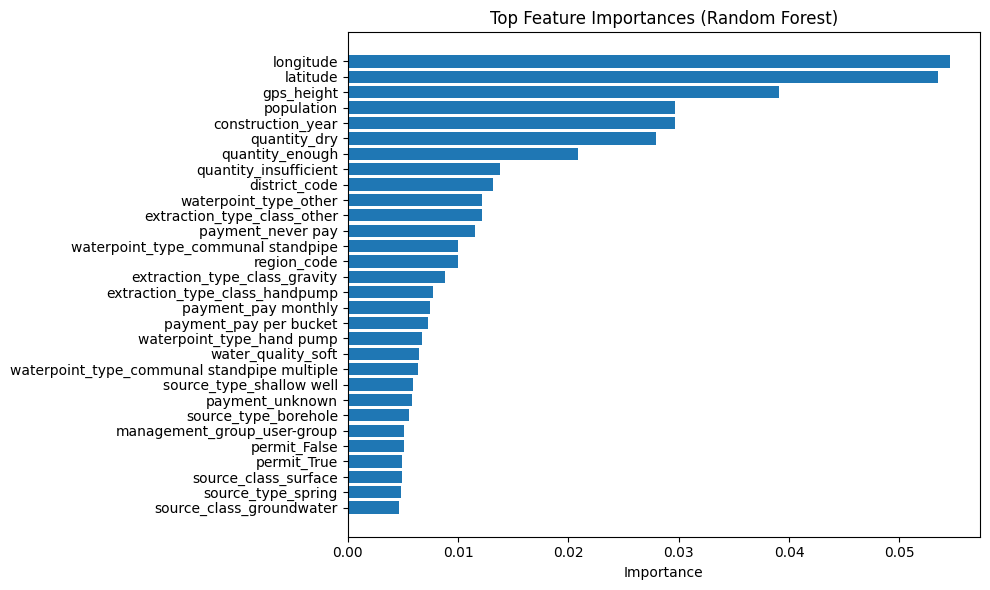

In [18]:
import matplotlib.pyplot as plt

top_n = 30
names, scores = zip(*feature_importances[:top_n])

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], scores[::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Time to bring in the actual test set for making the submission to the competiton

In [15]:
df_3 = pd.read_csv("../data/Test_Set_Values.csv")

In [16]:
X_test_ids = df_3['id'].copy()  # Store before dropping

In [17]:
df_3 = df_3.drop(columns=columns_to_drop)

In [18]:
preds_test = full_pipeline.predict(df_3)

In [19]:
# Convert back to original string labels
y_pred_labels = le.inverse_transform(preds_test)

# Then build submission
submission = pd.DataFrame({
    "id": X_test_ids.values,
    "status_group": y_pred_labels
})
submission.to_csv("submission.csv", index=False)


NameError: name 'le' is not defined

Submitting resut on drivendata with testset, public score = 0.76

In [24]:
##RANDOMIZED SEACRH

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'classifier__n_estimators': randint(100, 1000)
}

random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=50,             # Try 50 combinations
    cv=5,
    scoring='balanced_accuracy',    # or 'f1_macro', etc.
    random_state=42,
    n_jobs=-1,
    verbose=2
)


In [16]:
#GridSearch

from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

grid = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # or 'f1_macro', etc.
    n_jobs=-1,  # parallel processing
    verbose=2
)

Optimization using gridsearch

In [17]:
grid.fit(X_train, y_train_encoded)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Predict using the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......................classifier__n_estimators=100; total time= 3.1min
[CV] END .......................classifier__n_estimators=300; total time= 5.1min
[CV] END .......................classifier__n_estimators=600; total time= 8.0min


/home/amey/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .......................classifier__n_estimators=100; total time= 3.1min
[CV] END .......................classifier__n_estimators=300; total time= 5.2min
[CV] END .......................classifier__n_estimators=600; total time= 8.0min
[CV] END .......................classifier__n_estimators=100; total time= 3.2min
[CV] END .......................classifier__n_estimators=400; total time= 6.1min
[CV] END .......................classifier__n_estimators=600; total time= 8.1min
[CV] END .......................classifier__n_estimators=100; total time= 3.1min
[CV] END .......................classifier__n_estimators=400; total time= 6.2min
[CV] END .......................classifier__n_estimators=600; total time= 8.2min
[CV] END .......................classifier__n_estimators=200; total time= 4.1min
[CV] END .......................classifier__n_estimators=400; total time= 6.2min
[CV] END .......................classifier__n_estimators=600; total time= 8.1min
[CV] END ...................

In [26]:
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 40, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 620}
Best cross-validation score: 0.7018965084294856


Evaluation metrics

📊 Accuracy: 0.7986531986531986
🎯 Precision (macro): 0.7005041347622006
🎯 Recall (macro): 0.6859993515225341
🎯 F1 Score (macro): 0.6926549291563191
🎯 F1 Score (weighted): 0.7969620166690956
🧠 Cohen’s Kappa: 0.6315623693815646
📉 Log Loss: 0.5590424463299906
📈 ROC AUC Score (OvR): 0.8951444838671149

🧾 Classification Report:
                         precision    recall  f1-score   support

         non functional       0.82      0.79      0.81      4565
functional needs repair       0.46      0.41      0.43       863
             functional       0.82      0.85      0.84      6452

               accuracy                           0.80     11880
              macro avg       0.70      0.69      0.69     11880
           weighted avg       0.80      0.80      0.80     11880



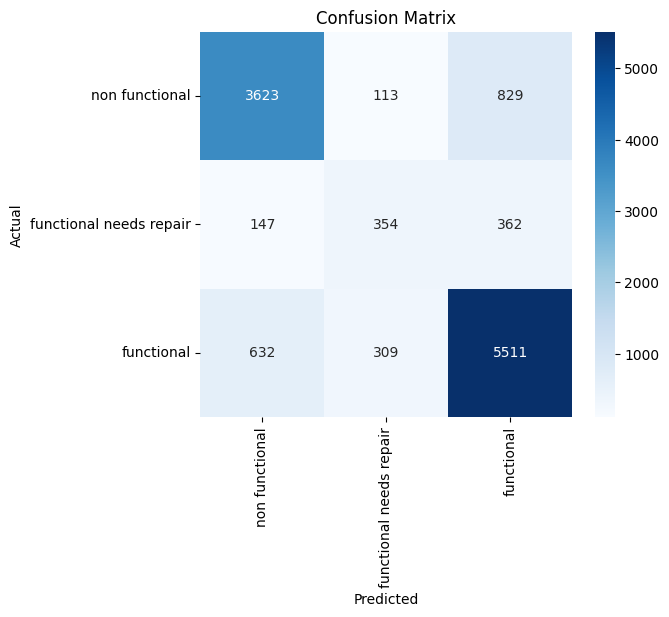


🔍 Class distribution comparison:
Predicted: 0    0.370539
1    0.065320
2    0.564141
Name: proportion, dtype: float64
True:      target
0    0.384259
1    0.072643
2    0.543098
Name: proportion, dtype: float64


In [12]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, log_loss,
    roc_auc_score, cohen_kappa_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

inv_target_map = {v: k for k, v in target_map_dict.items()}
class_names = [inv_target_map[i] for i in sorted(inv_target_map)]

# Label decoding if needed
y_true = y_test
y_pred_labels = y_pred  # use inverse_transform(y_pred) if label encoded
y_proba = full_pipeline.predict_proba(X_test)  # must be available for log_loss/roc_auc

# Basic Scores
print("📊 Accuracy:", accuracy_score(y_true, y_pred_labels))
print("🎯 Precision (macro):", precision_score(y_true, y_pred_labels, average='macro'))
print("🎯 Recall (macro):", recall_score(y_true, y_pred_labels, average='macro'))
print("🎯 F1 Score (macro):", f1_score(y_true, y_pred_labels, average='macro'))
print("🎯 F1 Score (weighted):", f1_score(y_true, y_pred_labels, average='weighted'))

# Cohen's Kappa
print("🧠 Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred_labels))

# Log Loss (requires probabilities)
try:
    print("📉 Log Loss:", log_loss(y_true, y_proba))
except:
    print("⚠️ Log loss not available (no predict_proba)")

# ROC AUC (multiclass)
try:
    print("📈 ROC AUC Score (OvR):", roc_auc_score(y_true, y_proba, multi_class='ovr'))
except:
    print("⚠️ ROC AUC not available (no predict_proba)")

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_names))

# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Prediction Distribution vs True Distribution
print("\n🔍 Class distribution comparison:")
print("Predicted:", pd.Series(y_pred_labels).value_counts(normalize=True).sort_index())
print("True:     ", pd.Series(y_true).value_counts(normalize=True).sort_index())


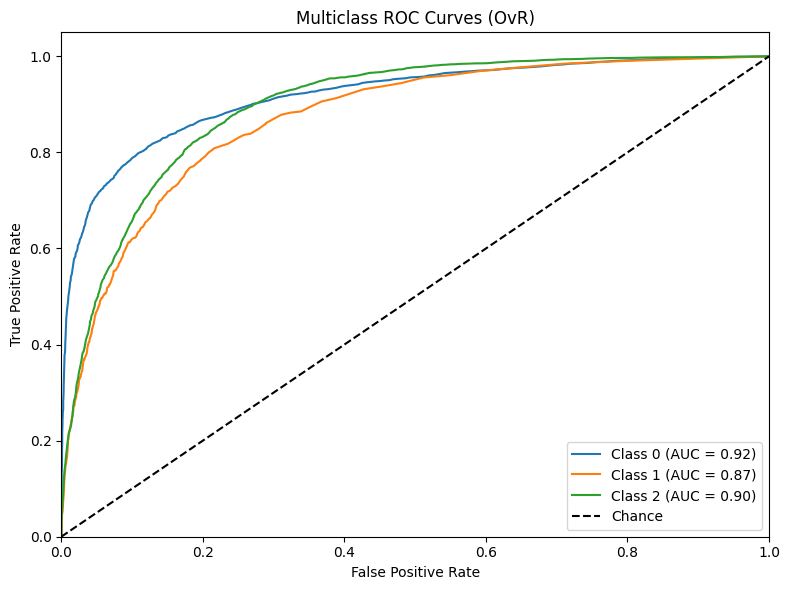

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Assuming y_true (integer labels) and y_proba (n_samples x n_classes)
# Also, target_map_dict = {'functional': 2, 'functional needs repair': 1, 'non functional': 0}
# Reverse map and binarize
classes = [0, 1, 2]  # or sorted list(target_map_dict.values())
y_test_bin = label_binarize(y_true, classes=classes)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (OvR)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


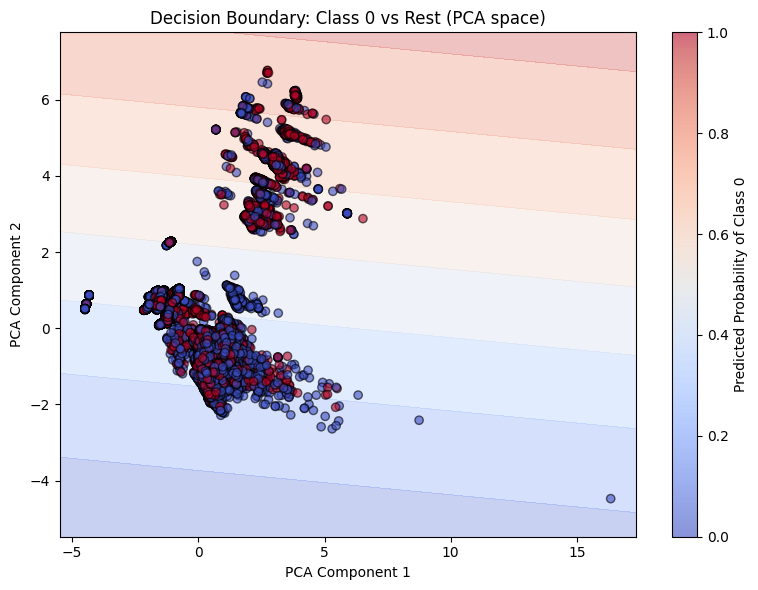

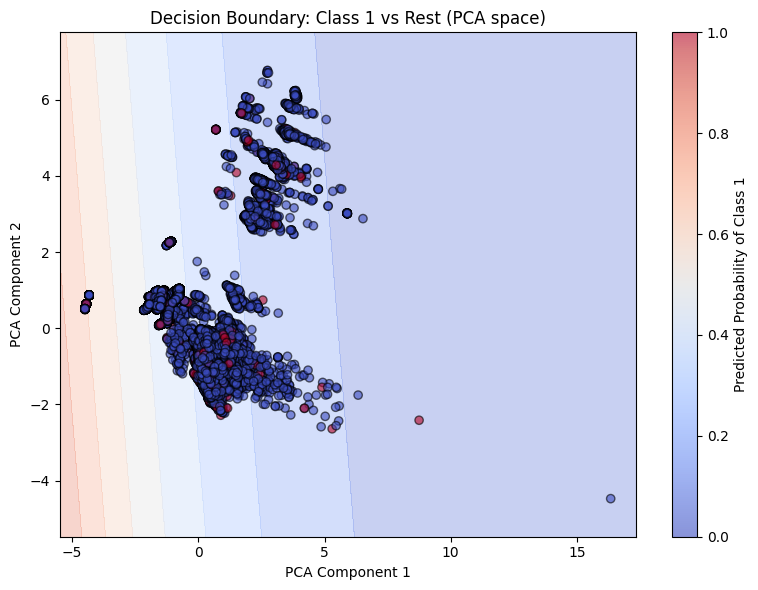

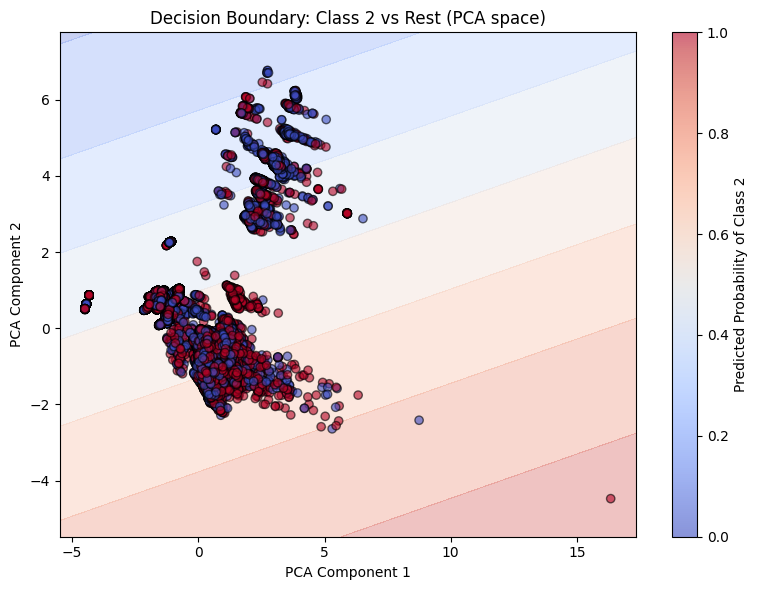

In [16]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Keep only numeric features
X_numeric = X.select_dtypes(include=[np.number])

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Step 3: Reduce to 2D with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Loop through each class
unique_classes = np.unique(y)  # e.g., [0, 1, 2]

for cls in unique_classes:
    # Create binary target: 1 for current class, 0 for others
    y_binary = (y == cls).astype(int)

    # Train 1-vs-rest classifier
    clf = LogisticRegression()
    clf.fit(X_pca, y_binary)

    # Generate meshgrid for decision boundary
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, edgecolors='k',
                cmap='coolwarm', alpha=0.6)
    plt.title(f"Decision Boundary: Class {cls} vs Rest (PCA space)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label=f"Predicted Probability of Class {cls}")
    plt.tight_layout()
    plt.show()


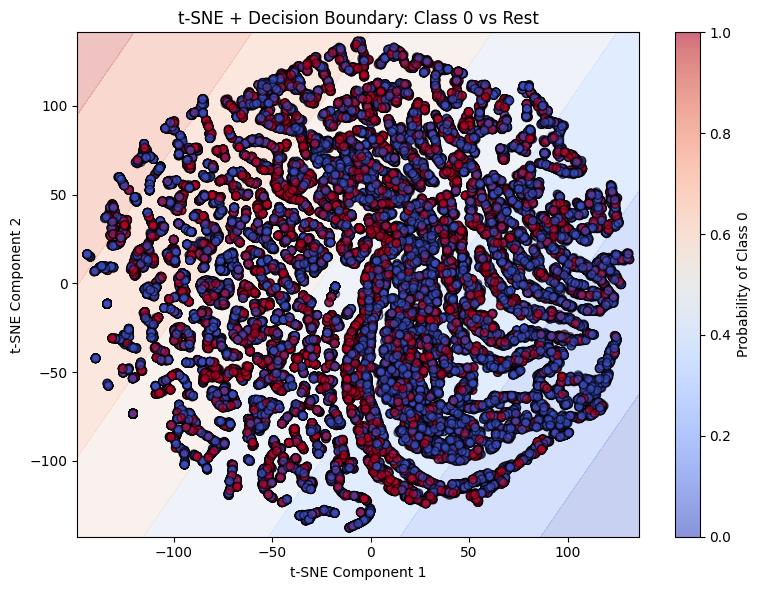

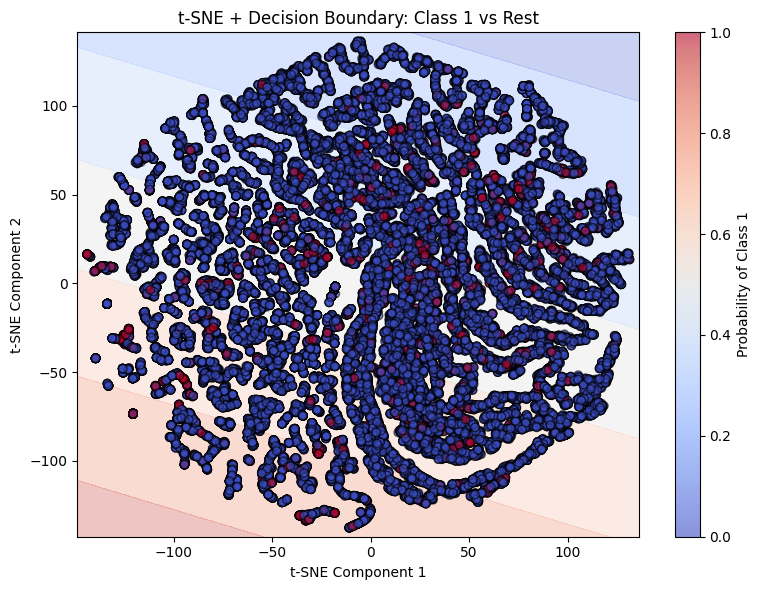

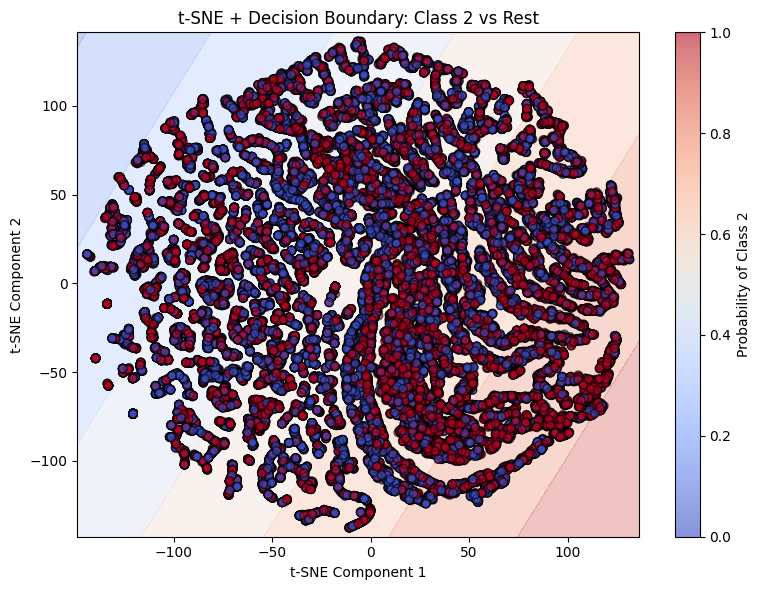

In [20]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_numeric)  # X_numeric: only numeric features

# Step 2: Loop through each class for 1-vs-rest
for cls in np.unique(y):
    y_binary = (y == cls).astype(int)

    clf = LogisticRegression()
    clf.fit(X_tsne, y_binary)

    # Decision boundary
    x_min, x_max = X_tsne[:, 0].min() - 5, X_tsne[:, 0].max() + 5
    y_min, y_max = X_tsne[:, 1].min() - 5, X_tsne[:, 1].max() + 5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_binary, edgecolors='k',
                cmap='coolwarm', alpha=0.6)
    plt.title(f"t-SNE + Decision Boundary: Class {cls} vs Rest")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.colorbar(label=f"Probability of Class {cls}")
    plt.tight_layout()
    plt.show()


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb

import pandas as pd

# Automatically select column types
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Define classifiers
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}


In [11]:
from sklearn.pipeline import Pipeline

# Build pipelines
pipelines = {
    name: Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ]) for name, model in models.items()
}


In [12]:
from sklearn.metrics import classification_report
import pandas as pd

results = {}

for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report["weighted avg"]


Training Decision Tree...


KeyboardInterrupt: 

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results).T
import ace_tools as tools; tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=results_df)
